In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

import utils.plots_cliffwalking as plots

from env.cliff_walking import WindyCliffWalking
from importlib import reload

# Solving Cliff Walking with Tabular Q-Learning

The [Cliff Walking](https://gymnasium.farama.org/environments/toy_text/cliff_walking/) environment is one of the simplest in reinforcement learning (RL), making it perfect for understanding the basics of tabular Q-Learning, a foundational algorithm for beginners. The premise of Cliff Walking is straightforward: the agent must navigate a grid from start to finish while avoiding falling off a cliff. If the agent falls, it is sent back to the start of the grid and receives a significant reward penalty.

<img src="media/cliff_walking.gif" width="200">
Here are some key details for modeling the environment as a Markov Decision Process (MDP):

Action Space
The action space is discrete and consists of integers in the range {0, 3}. Each action corresponds to a movement direction:

* 0: Up
* 1: Right
* 2: Down
* 3: Left

### State Space

The state represents the agent's position on the grid. The state space is also discrete, containing integers in the range {0, 47}. The numerical value of the agent’s position on the grid can be calculated using the formula:
current_row * nrows + column,
where rows and columns are zero-indexed.

### Rewards
The agent incurs a penalty of -1 for every move. Falling into the cliff results in a penalty of -100.


In [2]:
cliff_walking = gym.make('CliffWalking-v0')

## Creating the Q-Value Table

The Q-value table takes a pair (state, action) as input and returns the Q-value for that pair. A Q-value can be interpreted as "the expected total accumulated reward for taking action A in state S and then following the same policy until the end of the episode." Thus, we need one row in the table for each of the 48 states, with each row containing a column for each of the 4 possible actions. Additionally, the Q-values should be initialized with a default value (0.1 in our implementation).

<figure>
    <img src="media/qtable.png" alt="sample qtable" width="400">
    <figcaption> Exemplo de tabela de Qvalores. Fonte: <a href="https://www.datacamp.com/tutorial/introduction-q-learning-beginner-tutorial"> Datacamp </a> </figcaption>
</figure>

In [3]:
def new_q_table(n_states, n_actions):
    return np.full((n_states, n_actions), 0.1)

## Sampling Actions with the $\epsilon$-Greedy Policy

At the end of training, the best action for each state is expected to be the one with the highest Q-value. However, for Q-Learning to converge properly, it is crucial for the agent to thoroughly "explore" the environment at the beginning of training. This means visiting a wide range of states, even if they are not necessarily optimal. A widely used technique to achieve this is the $\epsilon$-greedy policy. It works by forcing the agent to choose random actions with a certain frequency, which gradually decreases as training progresses.

In [4]:
def get_action(q_table, state, epsilon):
    if np.random.random() < epsilon:
        return np.random.randint(0, q_table.shape[1])
    return np.argmax(q_table[state])

## Updating Q-Values Using the Bellman Equation

At each step of training, the agent will take an action and use the information returned by the environment to update its Q-values, thus learning the optimal table. The update of the Q-values is performed using the Bellman equation:

$$Q_{t+1}(s_t, a_t) = (1-\alpha) Q_t (s_t, a_t) + \alpha (R_{t+1} + \gamma \max_{a} Q_t (s_{t+1}, a))$$

In [5]:
def update_q_table(q_table, state, action, reward, next_state, terminated, alpha, gamma):
    if terminated:
        q_table[next_state] = np.zeros(q_table.shape[1]) # expected reward fof final state is 0

    q_table[state, action] = (1 - alpha) * q_table[state, action] + alpha * (reward + gamma * np.max(q_table[next_state]))
    return q_table

## Training Loop

In the training loop, we will combine all the functions developed so far. The main idea is to define a maximum number of episodes (from the initial stage to the final stage) so that the agent collects experiences from the environment and optimizes its Q-value table.

In [6]:
def train(env: gym.Env, 
          q_table,
          n_episodes=5000, # max episode number
          epsilon=0.99, # initial probability of taking a random action 
          epsilon_decay=0.999, # random action probability decay factor
          alpha=0.75, # learning rate
          gamma=0.99, # discount rate
          verbose=False):
     
    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        step = 0
        done = False

        if epsilon > 0.001:
            epsilon *= epsilon_decay
        
        while not done and step < 500: # 1000 steps max
            action = get_action(q_table, state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            q_table = update_q_table(q_table, state, action, reward, next_state, terminated, alpha, gamma)
            state = next_state
            total_reward += reward

            done = terminated or truncated
            step += 1
            
        if episode % 100 == 0 and verbose:
            print(f"Episode {episode} - Total reward: {total_reward} - epsilon: {epsilon}")

    return q_table

## Training

Everything is set up, so now we can run the algorithm!

In [7]:
q_table = new_q_table(n_states=48, n_actions=4)
trained_q_table = train(cliff_walking, q_table, alpha=0.75, verbose=True)

Episode 0 - Total reward: -5747 - epsilon: 0.98901
Episode 100 - Total reward: -2069 - epsilon: 0.8948484814169296
Episode 200 - Total reward: -152 - epsilon: 0.8096518788426657
Episode 300 - Total reward: -582 - epsilon: 0.7325666618727043
Episode 400 - Total reward: -751 - epsilon: 0.6628205628997266
Episode 500 - Total reward: -128 - epsilon: 0.5997148402571608
Episode 600 - Total reward: -136 - epsilon: 0.5426172779722319
Episode 700 - Total reward: -747 - epsilon: 0.4909558519974922
Episode 800 - Total reward: -557 - epsilon: 0.4442129994668515
Episode 900 - Total reward: -19 - epsilon: 0.40192043356343343
Episode 1000 - Total reward: -25 - epsilon: 0.3636544520527319
Episode 1100 - Total reward: -123 - epsilon: 0.3290316924802508
Episode 1200 - Total reward: -125 - epsilon: 0.2977052915076636
Episode 1300 - Total reward: -129 - epsilon: 0.26936140991033175
Episode 1400 - Total reward: -133 - epsilon: 0.24371608842234507
Episode 1500 - Total reward: -20 - epsilon: 0.22051240292980

## Testing the agent

The function below will run an episode with the trained agent.

In [8]:
def test(env: gym.Env, 
          q_table,
          n_episodes=1,
          verbose=False
          ):
    
    total_rewards = []
    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = get_action(q_table, state, 0)
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward

            done = terminated or truncated

        if verbose:
            print(f"Episode {episode} - Total reward: {total_reward}")
            
        total_rewards.append(total_reward)

    env.close()
    return np.average(total_reward)

# test(gym.make('CliffWalking-v0', render_mode="human"), trained_q_table)

## Results Analysis

### Visualizing the Policy

The cell below will allow observing the most likely action to be taken in each position on the board.

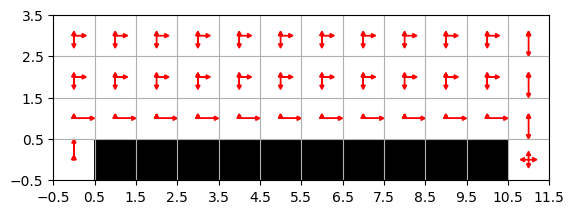

<Figure size 640x480 with 0 Axes>

In [9]:
reload(plots)
plots.plot_arrows_from_qtable(trained_q_table)

### Visualizing the Influence of the Learning Rate

The cell below will create a graph showing the average total reward of a set of agents trained with different learning rates. How would you explain the results?

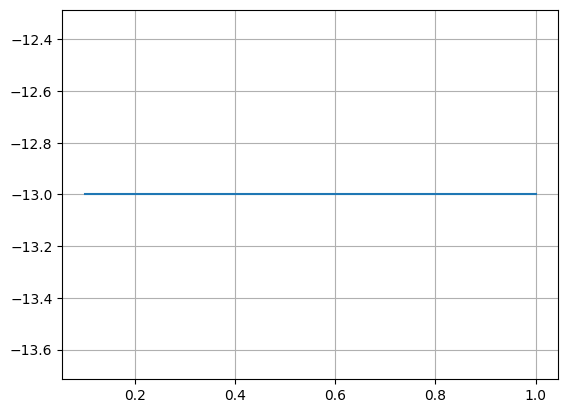

In [10]:
# average expected return as a function of alpha

def plot_avg_return_x_alpha(n_samples=100, n_alphas=10 ):
    avg_returns = []
    alphas=np.linspace(0.1, 1, n_alphas)
 
    for alpha in alphas:
        q_table = new_q_table(n_states=48, n_actions=4)
        trained_q_table = train(cliff_walking, q_table, alpha=alpha)
        avg_returns.append(test(cliff_walking, trained_q_table, n_samples))

    plt.plot(alphas, avg_returns)
    plt.grid()
    plt.show()

plot_avg_return_x_alpha(n_samples=100, n_alphas=10)

## Exercise - Non-Deterministic Environments
Now that we have seen the agent learn a path to the goal that minimizes the distance walked and avoids the cliff, it's time to make things a bit more challenging. We will now use a modified version of Cliff Walking that adds random wind toward the cliff. In other words, there is a probability that the agent will be involuntarily displaced one step down.

This change will be interesting for observing the influence of the learning rate on training a model robust to non-deterministic environments.

In [11]:
windy_cliff_walking = WindyCliffWalking(wind=0.5)

windy_q_table = new_q_table(n_states=48, n_actions=4)
trained_windy_q_table = train(windy_cliff_walking, windy_q_table, alpha=0.75, verbose=True)

Episode 0 - Total reward: -6935 - epsilon: 0.98901
Episode 100 - Total reward: -6044 - epsilon: 0.8948484814169296
Episode 200 - Total reward: -4856 - epsilon: 0.8096518788426657
Episode 300 - Total reward: -5747 - epsilon: 0.7325666618727043
Episode 400 - Total reward: -3866 - epsilon: 0.6628205628997266
Episode 500 - Total reward: -3965 - epsilon: 0.5997148402571608
Episode 600 - Total reward: -3866 - epsilon: 0.5426172779722319
Episode 700 - Total reward: -5054 - epsilon: 0.4909558519974922
Episode 800 - Total reward: -1243 - epsilon: 0.4442129994668515
Episode 900 - Total reward: -2054 - epsilon: 0.40192043356343343
Episode 1000 - Total reward: -1600 - epsilon: 0.3636544520527319
Episode 1100 - Total reward: -2233 - epsilon: 0.3290316924802508
Episode 1200 - Total reward: -404 - epsilon: 0.2977052915076636
Episode 1300 - Total reward: -1241 - epsilon: 0.26936140991033175
Episode 1400 - Total reward: -1260 - epsilon: 0.24371608842234507
Episode 1500 - Total reward: -31 - epsilon: 0.

### Results

In [12]:
windy_cliff_walking.render_mode = 'human'
# test(windy_cliff_walking, trained_windy_q_table)

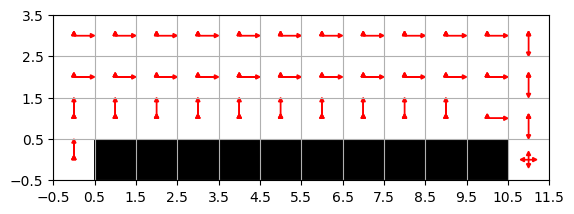

<Figure size 640x480 with 0 Axes>

In [13]:
plots.plot_arrows_from_qtable(trained_windy_q_table)